Create pandas DataFrame
                                col2
test                                
2019-05-20 11:01:51.021691  0.000000
2019-05-21 11:01:51.021691  0.003927
2019-05-22 11:01:51.021691  0.007854
2019-05-23 11:01:51.021691  0.011781
2019-05-24 11:01:51.021691  0.015707
2019-05-25 11:01:51.021691  0.019634
2019-05-26 11:01:51.021691  0.023560
2019-05-27 11:01:51.021691  0.027485
2019-05-28 11:01:51.021691  0.031411
2019-05-29 11:01:51.021691  0.035336
2019-05-30 11:01:51.021691  0.039260
2019-05-31 11:01:51.021691  0.043183
2019-06-01 11:01:51.021691  0.047106
2019-06-02 11:01:51.021691  0.051029
2019-06-03 11:01:51.021691  0.054950
2019-06-04 11:01:51.021691  0.058871
2019-06-05 11:01:51.021691  0.062791
2019-06-06 11:01:51.021691  0.066709
2019-06-07 11:01:51.021691  0.070627
2019-06-08 11:01:51.021691  0.074544
2019-06-09 11:01:51.021691  0.078459
2019-06-10 11:01:51.021691  0.082373
2019-06-11 11:01:51.021691  0.086286
2019-06-12 11:01:51.021691  0.090198
2019-06-13 11:

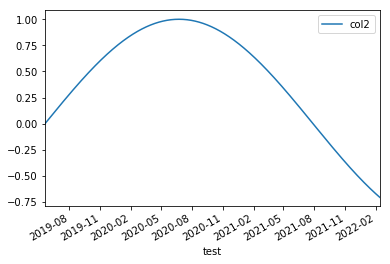

In [7]:
from influxdb import InfluxDBClient
from influxdb import DataFrameClient
import math
import datetime
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


HOST = 'dbod-lhc-sm.cern.ch'
PORT = 8081
USER = 'root'
PASSWD = 'root'
DATABASE = 'test'
SSL = True

df_client = DataFrameClient(host=HOST,
                        port=PORT,
                        username=USER,
                        password=PASSWD,
                        database=DATABASE,
                        ssl=SSL)


print("Create pandas DataFrame")

Fs = 8000
f = 5
sample = 1000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)

date_today = datetime.now()
days = pd.date_range(date_today, date_today + timedelta(len(x)-1), freq='D')

df = pd.DataFrame({'test': days, 'col2': y})
df = df.set_index('test')

print(df)
df.plot()


In [8]:
print(df_client._database)

test


In [10]:
print("Write DataFrame")
df_client.write_points(df, 'sine', {'unit': 'Unit' },  protocol='json')

Write DataFrame


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3python3/Mon/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


True

In [11]:
queried = df_client.query("select * from sine")
print(queried)


{}


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3python3/Mon/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [6]:
print(type(queried))
queried.items()
sine = pd.DataFrame.from_dict(queried,  orient='index')
print(sine)

<class 'collections.defaultdict'>
                                                      0
sine                                           col2 ...


In [7]:
val = queried.get('sine')
print(val)

                                         col2  unit
2019-03-05 10:13:49.082066944+00:00  0.000000  Unit
2019-03-05 11:31:38.890661888+00:00  0.000000  unit
2019-03-06 10:13:49.082066944+00:00  0.003927  Unit
2019-03-06 11:31:38.890661888+00:00  0.003927  unit
2019-03-07 10:13:49.082066944+00:00  0.007854  Unit
2019-03-07 11:31:38.890661888+00:00  0.007854  unit
2019-03-08 10:13:49.082066944+00:00  0.011781  Unit
2019-03-08 11:31:38.890661888+00:00  0.011781  unit
2019-03-09 10:13:49.082066944+00:00  0.015707  Unit
2019-03-09 11:31:38.890661888+00:00  0.015707  unit
2019-03-10 10:13:49.082066944+00:00  0.019634  Unit
2019-03-10 11:31:38.890661888+00:00  0.019634  unit
2019-03-11 10:13:49.082066944+00:00  0.023560  Unit
2019-03-11 11:31:38.890661888+00:00  0.023560  unit
2019-03-12 10:13:49.082066944+00:00  0.027485  Unit
2019-03-12 11:31:38.890661888+00:00  0.027485  unit
2019-03-13 10:13:49.082066944+00:00  0.031411  Unit
2019-03-13 11:31:38.890661888+00:00  0.031411  unit
2019-03-13 1

In [8]:
class Object(object):
    def __init__(self,label=None, df=None, unit=None):
        self.label =label
        self.df = df
        self.unit = unit
    
    def read(self, label=None, query=None):
        if label is not None:
            self.label = label
        queryString = "select * from {0}".format(self.label)
        if query is not None:
            queryString = query
            *tokens, last = queryString.split()
            self.label = last
        
        queryResult = df_client.query(queryString)
        self.df = queryResult.get(self.label)
        # check for 'unit tag' - might be deprecated when adjusting for signalPM and signalCALS: 
        if 'unit' in self.df.columns:
            self.unit = self.df['unit'].iloc[0]
        return self.df

In [9]:
obj1 = Object('sine')
obj2 = Object('not_sine')
obj3 = Object()

print(obj1.label)
print(obj2.label)
print(obj3.label)

sine
not_sine
None


In [10]:
result1 = obj1.read()
result2 = obj2.read('sine')
result3 = obj3.read(query="select (col2 *2) from sine")

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3python3/Tue/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3python3/Tue/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3python3/Tue/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.read

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


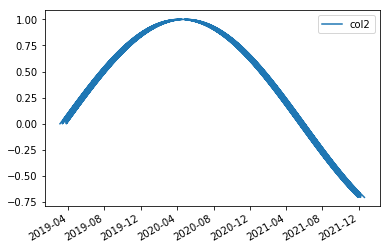

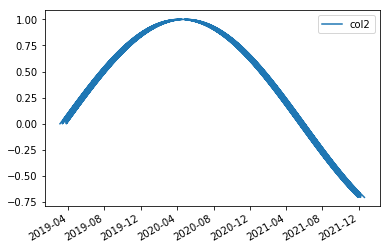

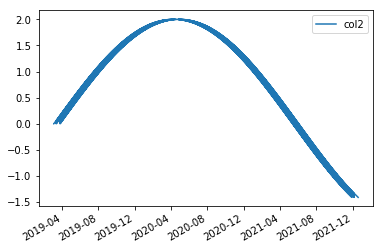

In [11]:
print(type(result1))
result1.plot()

print(type(result2))
result2.plot()

print(type(result3))
result3.plot()

Unit
Unit
None


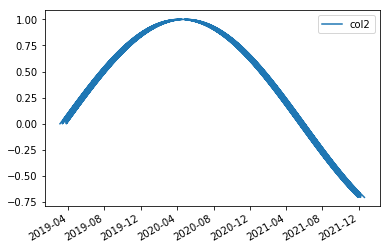

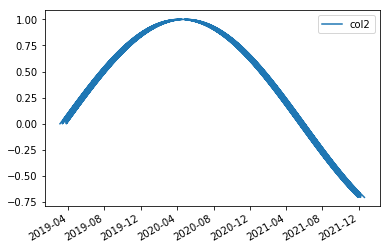

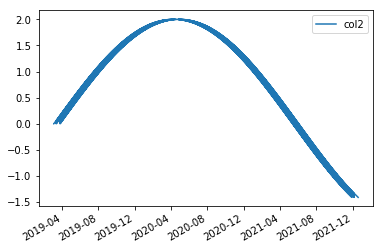

In [12]:
obj1.df.plot()
obj2.df.plot()
obj3.df.plot()
print(obj1.unit)
print(obj2.unit)
print(obj3.unit)